# Traditional Forecasting of Volatility using GARCH Framework 

Forecast realized volatility using a GARCH (1, 1) model on log returns for the S&P 500 stocks. 

We start by processing the log returns, fiting a Garch (1, 1), out of sample forecasting and compare it to the realized volatility

In [1]:
#Import libraries 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf



In [2]:
#Import returns data from csv file
path = '/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/data/log_returns.csv'
log_returns = pd.read_csv(path, index_col=0, parse_dates=True)
log_returns = log_returns.dropna()

print(log_returns.head())


                INVH      TMUS      WYNN       MGM         V      EPAM  \
Date                                                                     
2019-05-28 -0.014068 -0.017757 -0.000788 -0.008651  0.006557 -0.002154   
2019-05-29 -0.005525  0.002894  0.002451  0.001578 -0.006004 -0.001079   
2019-05-30  0.005918 -0.001314 -0.026217 -0.000789  0.000184  0.036907   
2019-05-31  0.008227 -0.034659 -0.037488 -0.020734 -0.008825 -0.002604   
2019-06-03  0.006611  0.010295 -0.035660 -0.039027 -0.017067 -0.057967   

                GILD       TMO       BBY      AAPL  ...        CB       CRM  \
Date                                                ...                       
2019-05-28 -0.044635 -0.020142 -0.008223 -0.004143  ... -0.011608  0.004391   
2019-05-29 -0.009424 -0.006100 -0.013237 -0.004781  ... -0.003420 -0.014932   
2019-05-30 -0.000473  0.012089  0.007256  0.005173  ... -0.001234  0.017956   
2019-05-31 -0.017359 -0.003739 -0.036658 -0.018282  ...  0.001988 -0.027683   
2019-06

In [8]:
data = yf.download('^GSPC', start='2015-01-01', end='2025-04-01', group_by='ticker', progress=False)

#Handle missing data
data = data.dropna(axis=1, thresh=(len(data) * 0.9))  # Corrected: 'tresh' to 'thresh'
data = data.ffill()  # Forward fill missing data

#Isolating the close columns from the MultiIndex

sp_500 = data.loc[:, pd.IndexSlice[:, 'Close']] 
sp_500.columns = sp_500.columns.get_level_values(0)  # Flatten the MultiIndex

print(sp_500.head()) 

Ticker            ^GSPC
Date                   
2015-01-02  2058.199951
2015-01-05  2020.579956
2015-01-06  2002.609985
2015-01-07  2025.900024
2015-01-08  2062.139893


In [3]:
#Fit a GARCH(1,1) model to the log returns of AAPL 

#Select ticker symbol and convert to percentage
ticker = 'AAPL'
aapl_returns = log_returns[ticker].dropna() * 100 # Convert to percentage

#Fit a GARCH(1,1) model 
model = arch_model(aapl_returns, vol='Garch', p=1, q=1, dist='normal')
results = model.fit(disp='off')
print(results.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2899.19
Distribution:                  Normal   AIC:                           5806.38
Method:            Maximum Likelihood   BIC:                           5827.55
                                        No. Observations:                 1470
Date:                Tue, Apr 01 2025   Df Residuals:                     1469
Time:                        16:52:40   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1620  4.465e-02      3.628  2.857e-04 [7.447e-0

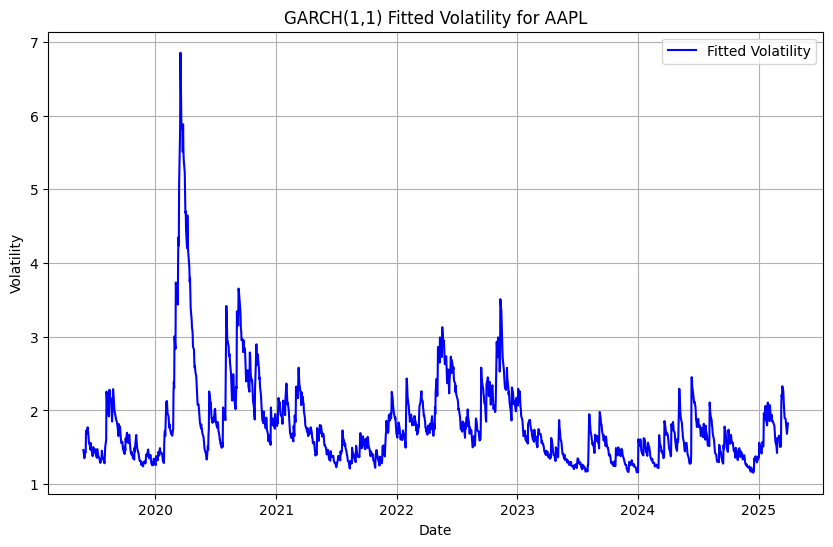

In [4]:

#Plot the fitted volatility (in-sample)
figsize = (10, 6)
plt.figure(figsize=figsize)
plt.plot(results.conditional_volatility, label='Fitted Volatility', color='blue')
plt.title(f'GARCH(1,1) Fitted Volatility for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

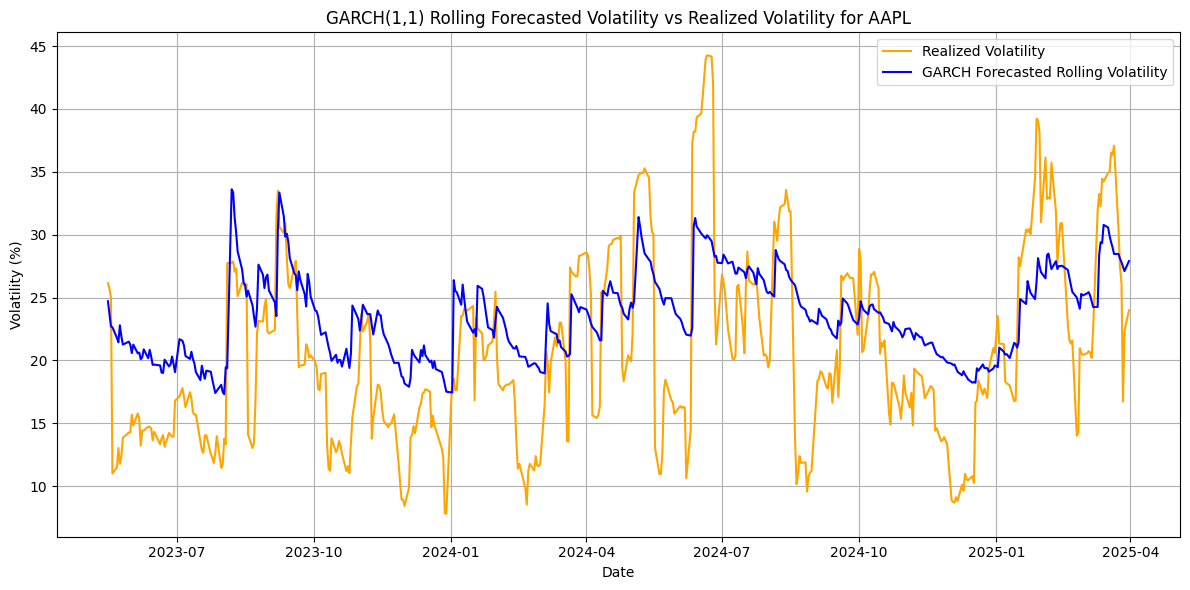

In [5]:
# Rolling forecast (out-of-sample)

# Params
window_size = 1000 
forecast_horizon = 1
rolling_vol = []

for i in range(window_size, len(aapl_returns)):
    train = aapl_returns[i - window_size:i] # Convert to percentage
    
    model = arch_model(train, vol='Garch', p=1, q=1, dist='normal')
    results = model.fit(disp='off')
    
    forecast = results.forecast(horizon=forecast_horizon)
    vol = np.sqrt(forecast.variance.values[-1, 0]) * np.sqrt(252)  # Annualize the volatility
    rolling_vol.append(vol)

# Align forecast index
rolling_vol = pd.Series(rolling_vol, index=aapl_returns.index[window_size:])
rolling_vol.name = 'GARCH Forecasted Rolling Volatility'

# Load realized volatility for comparison
vol_path = '/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/data/realized_vol_10d.csv'
realized_vol = pd.read_csv(vol_path, index_col=0, parse_dates=True)

# Format and align
realized_vol = realized_vol['AAPL'].dropna() * 100  # convert to %
realized_vol = realized_vol.loc[rolling_vol.index]

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(realized_vol, label='Realized Volatility', color='orange')
plt.plot(rolling_vol, label='GARCH Forecasted Rolling Volatility', color='blue')
plt.title(f'GARCH(1,1) Rolling Forecasted Volatility vs Realized Volatility for AAPL')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [6]:
print('Sample realized volatility values:', realized_vol.tail(10))
print('Sample GARCH forecasted rolling volatility values:', rolling_vol.tail(10))
print(train.describe)

Sample realized volatility values: Date
2025-03-18    34.995230
2025-03-19    36.518629
2025-03-20    36.360896
2025-03-21    37.080814
2025-03-24    30.418369
2025-03-25    27.420246
2025-03-26    26.179914
2025-03-27    16.738206
2025-03-28    22.374490
2025-03-31    23.985537
Name: AAPL, dtype: float64
Sample GARCH forecasted rolling volatility values: Date
2025-03-18    29.927798
2025-03-19    29.405940
2025-03-20    28.998610
2025-03-21    28.471508
2025-03-24    28.474063
2025-03-25    28.092593
2025-03-26    27.814694
2025-03-27    27.468857
2025-03-28    27.109937
2025-03-31    27.901512
Name: GARCH Forecasted Rolling Volatility, dtype: float64
<bound method NDFrame.describe of Date
2021-04-07    1.330141
2021-04-08    1.905108
2021-04-09    2.004935
2021-04-12   -1.332135
2021-04-13    2.401604
                ...   
2025-03-24    1.120737
2025-03-25    1.358914
2025-03-26   -0.997134
2025-03-27    1.041820
2025-03-28   -2.694000
Name: AAPL, Length: 1000, dtype: float64>


## Comparing out-of-sample with realized volatility

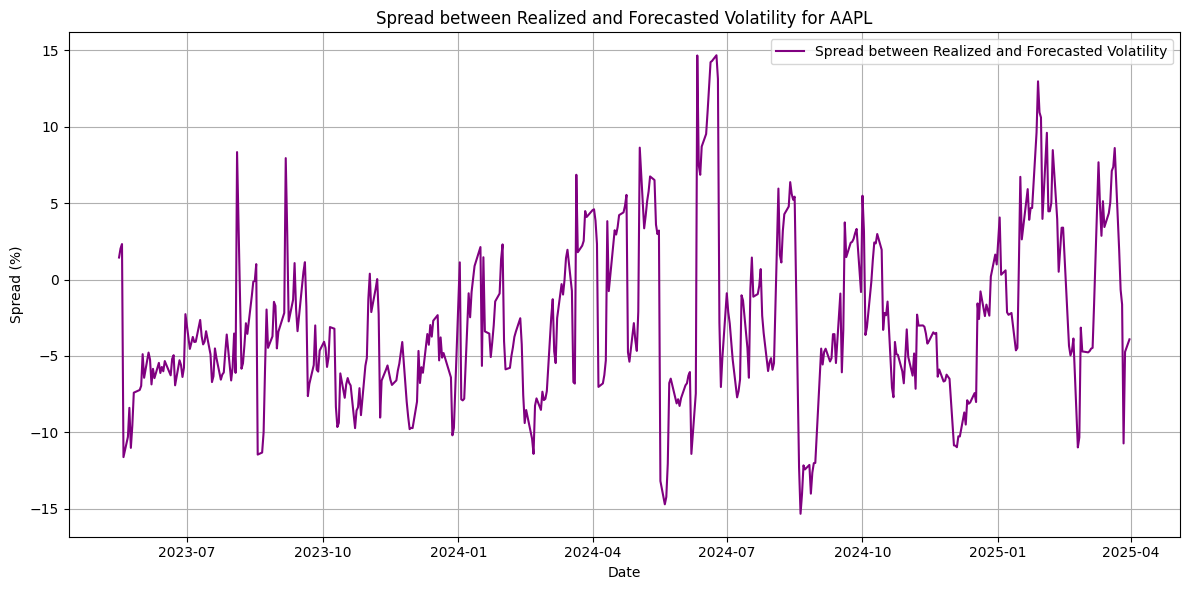

In [7]:
# Spread between realized volatility and GARCH forecasted rolling volatility
spread = realized_vol - rolling_vol
plt.figure(figsize=(12, 6))
plt.plot(spread, label='Spread between Realized and Forecasted Volatility', color='purple')
plt.title(f'Spread between Realized and Forecasted Volatility for {ticker}')
plt.xlabel('Date')
plt.ylabel('Spread (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


_______

## GARCH Performance on AAPL
- RMSE: 6.09: On average, the forecast deviates from realized vol by ~6 percentage points
- MAE: 5.23: Median-ish absolute error — cleaner than RMSE for outlier spikes
- MAPE: 32.28%: On average, the model is ~32% off from realized volatility

---------

## Interpretation

These are reasonable results for a GARCH(1,1) model on a high-volatility stock like AAPL. GARCH is known for:
- Strength: capturing volatility clustering
- Weakness: lagging rapid spikes (like earnings or macro shocks)

A MAPE around 30% is typical for traditional models. So now:
